In [2]:
# !mkdir -p QuantitativeFinanceProject/data/raw
# !mkdir -p QuantitativeFinanceProject/data/processed
# !mkdir -p QuantitativeFinanceProject/src/data_collection
# !mkdir -p QuantitativeFinanceProject/src/analysis
# !mkdir -p QuantitativeFinanceProject/src/strategies
# !mkdir -p QuantitativeFinanceProject/src/visualization
# !mkdir -p QuantitativeFinanceProject/src/utils

# !touch QuantitativeFinanceProject/src/data_collection/load_data.py
# !touch QuantitativeFinanceProject/src/data_collection/resample_data.py
# !touch QuantitativeFinanceProject/src/data_collection/fetch_options.py

# !touch QuantitativeFinanceProject/src/analysis/calculate_returns.py
# !touch QuantitativeFinanceProject/src/analysis/technical_indicators.py
# !touch QuantitativeFinanceProject/src/analysis/seasonality_analysis.py
# !touch QuantitativeFinanceProject/src/analysis/implied_volatility.py

# !touch QuantitativeFinanceProject/src/strategies/kelly_criterion.py
# !touch QuantitativeFinanceProject/src/strategies/position_sizing.py
# !touch QuantitativeFinanceProject/src/strategies/backtest_strategy.py

# !touch QuantitativeFinanceProject/src/visualization/plot_data.py
# !touch QuantitativeFinanceProject/src/visualization/plot_strategy.py

# !touch QuantitativeFinanceProject/src/utils/helpers.py

# !touch QuantitativeFinanceProject/src/main.py


In [89]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import linregress
from datetime import datetime
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")


# Set the current date
current_date = datetime.now().strftime('%Y-%m-%d')

c:\ProgramData\anaconda3\envs\jupyter-ai\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\ProgramData\anaconda3\envs\jupyter-ai\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\ProgramData\anaconda3\envs\jupyter-ai\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  3 of 3 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10568\3979381822.py:1

,QQQ,SPY,^GDAXI
Date,,,
2015-01-05,-0.014669,-0.018060,-0.029860
2015-01-06,-0.013408,-0.009419,-0.000369
2015-01-07,0.012891,0.012461,0.005124
2015-01-08,0.019140,0.017745,0.033560
2015-01-09,-0.006583,-0.008014,-0.019223


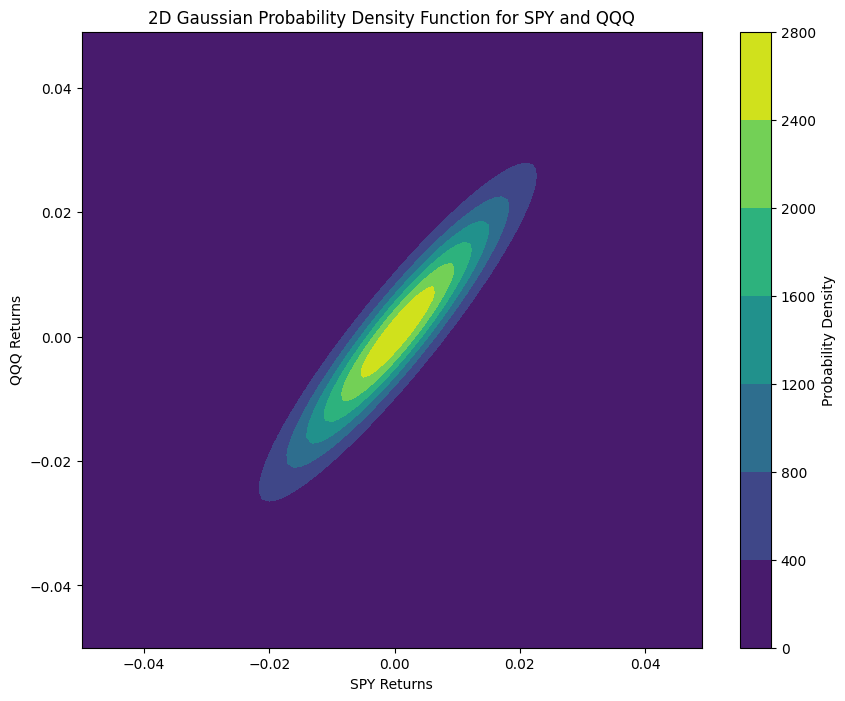

Value-at-Risk (VaR) at 95.0% confidence level: -0.020374927257457296


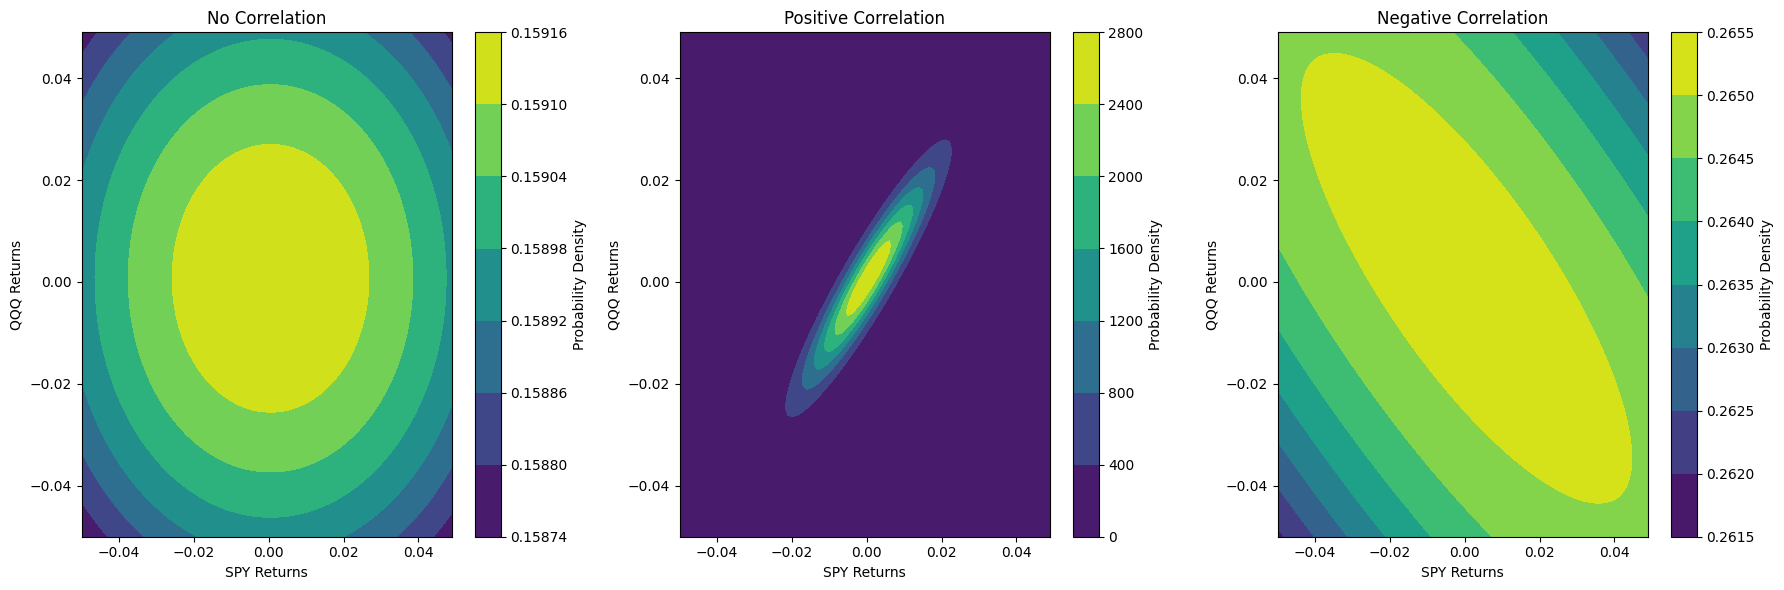

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10568\4108808362.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data['SPY'][-1]  # Last closing price of SPY


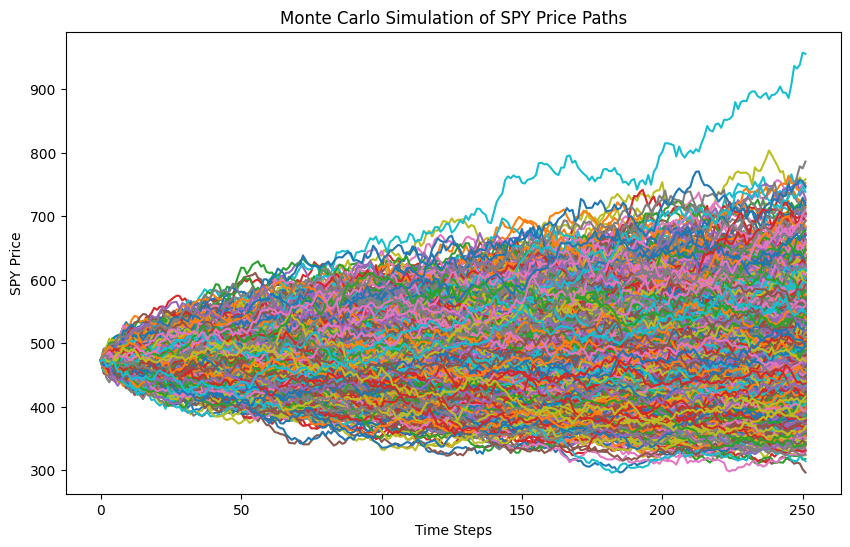

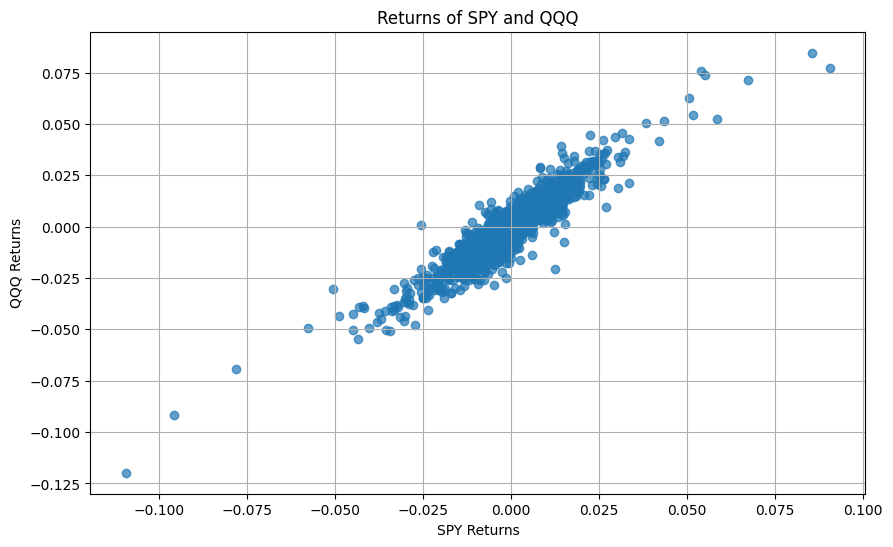

Correlation coefficient between SPY and QQQ: 0.9290105240068351


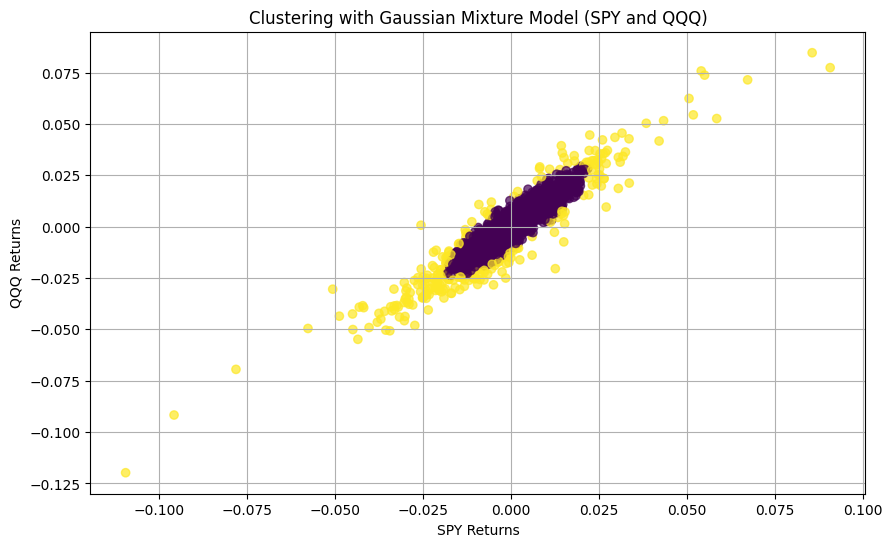

In [91]:
def load_data(ticker='SPY', start='2008-01-01', end=None):
    """
    Load historical data for a given ticker using yfinance.
    """
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df


# Resample data
def resample_monthly(df):
    """
    Resample the dataframe to monthly frequency.
    """
    df_monthly = df.resample('M').ffill()
    return df_monthly  

def calculate_returns(df, period='M'):
    """
    Calculate percentage returns based on the specified period.
    """
    df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
    df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
    return df


def calculate_technical_indicators(df):
    """
    Calculate RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

    # Calculate MACD
    df['12 EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 EMA'] - df['26 EMA']
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

def fetch_fed_data(series, start_date='2008-01-01'):
    """
    Fetch macroeconomic data from FRED.
    """
    return pdr.get_data_fred(series, start=start_date)

def merge_macro_data(financial_df, macro_df):
    """
    Merge financial data with macroeconomic data.
    """
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    return merged_df


def create_seasonality_table(df, column='Return'):
    """
    Create a pivot table for seasonality analysis.
    """
    seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    # Ensure all months are represented
    seasonality_table = seasonality_table.reindex(columns=range(1, 13))
    seasonality_table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    seasonality_table = seasonality_table.transpose()
    return seasonality_table

def visualize_seasonality_table(seasonality_table):
    """
    Visualize the seasonality table using a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_table, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
    plt.title('Seasonality of Index Fund Returns')
    plt.show()

def extract_monthly_data(seasonality_table, month):
    """
    Extract data for a specific month.
    """
    return seasonality_table.loc[month]

def visualize_monthly_data(monthly_data, month):
    """
    Visualize the extracted data for the selected month.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue')
    plt.xlabel('Year')
    plt.ylabel(f'Average {month} Return (%)')
    plt.title(f'Average {month} Returns Over the Years')
    plt.xticks(rotation=45)
    plt.show()

def perform_quantitative_analysis(monthly_data, month):
    """
    Perform quantitative analysis on the extracted monthly data.
    """
    mean_return = monthly_data.mean()
    std_return = monthly_data.std()
    highest_return_year = monthly_data.idxmax()
    highest_return_value = monthly_data.max()
    lowest_return_year = monthly_data.idxmin()
    lowest_return_value = monthly_data.min()

    print(f"Mean {month} Return: {mean_return:.2f}%")
    print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
    print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
    print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")

    # Determine Overall Trend
    years = monthly_data.index.astype(int)
    returns = monthly_data.values
    if len(set(returns)) > 1:  # Check for variance in data
        slope, intercept, r_value, p_value, std_err = linregress(years, returns)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue', label=f'{month} Return')
        plt.plot(monthly_data.index, intercept + slope*years, 'r', label=f'Trend Line (slope={slope:.2f})')
        plt.xlabel('Year')
        plt.ylabel(f'Average {month} Return (%)')
        plt.title(f'Average {month} Returns Over the Years with Trend Line')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        print(f"Trend Line Slope: {slope:.2f}% per year")
        print(f"R-squared: {r_value**2:.2f}")
    else:
        print(f"No variance in {month} data to compute trend line.")

def display_all_monthly_statistics(seasonality_table, seasonality_volume_table):
    """
    Display the statistics for each month in the seasonality table.
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in months:
        monthly_data = seasonality_table.loc[month]
        monthly_volume = seasonality_volume_table.loc[month]
        mean_return = monthly_data.mean()
        std_return = monthly_data.std()
        highest_return_year = monthly_data.idxmax()
        highest_return_value = monthly_data.max()
        lowest_return_year = monthly_data.idxmin()
        lowest_return_value = monthly_data.min()
        mean_volume = monthly_volume.mean()
        highest_volume_year = monthly_volume.idxmax()
        highest_volume_value = monthly_volume.max()
        lowest_volume_year = monthly_volume.idxmin()
        lowest_volume_value = monthly_volume.min()

        print(f"Mean {month} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
        print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {month} Volume: {mean_volume:.2f}")
        print(f"Highest {month} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {month} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print()


## SPY Seasonalnality

[*********************100%%**********************]  1 of 1 completed


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24128\2302045975.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24128\2302045975.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24128\2302045975.py:71: FutureWarning: The provided callable <function mean at 0x0000019CCB1BE480> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2

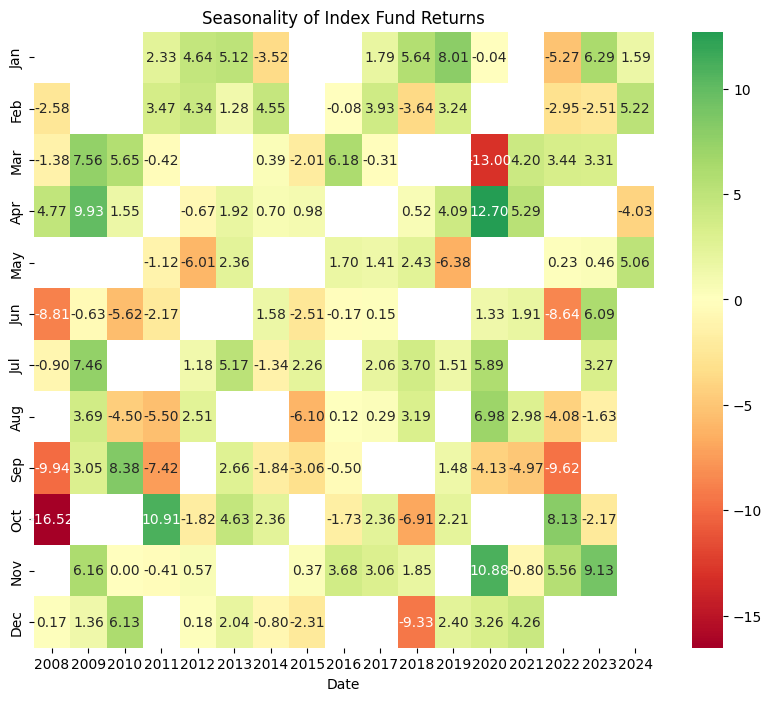

Mean Jan Return: 2.41%
Standard Deviation of Jan Returns: 4.13%
Highest Jan Return: 8.01% in 2019
Lowest Jan Return: -5.27% in 2022
Mean Jan Volume: 2469885075.00
Highest Jan Volume: 6106834300.00 in 2008
Lowest Jan Volume: 1392003800.00 in 2020

Mean Feb Return: 1.19%
Standard Deviation of Feb Returns: 3.36%
Highest Feb Return: 5.22% in 2024
Lowest Feb Return: -3.64% in 2018
Mean Feb Volume: 2393097408.33
Highest Feb Volume: 4151028600.00 in 2008
Lowest Feb Volume: 1365136600.00 in 2017

Mean Mar Return: 1.13%
Standard Deviation of Mar Returns: 5.46%
Highest Mar Return: 7.56% in 2009
Lowest Mar Return: -13.00% in 2020
Mean Mar Volume: 3811389666.67
Highest Mar Volume: 8813959700.00 in 2009
Lowest Mar Volume: 1921474100.00 in 2017

Mean Apr Return: 3.14%
Standard Deviation of Apr Returns: 4.60%
Highest Apr Return: 12.70% in 2020
Lowest Apr Return: -4.03% in 2024
Mean Apr Volume: 2777673275.00
Highest Apr Volume: 6023006600.00 in 2009
Lowest Apr Volume: 1209204700.00 in 2019

Mean May R

In [92]:
# Main execution for SPY
ticker = 'SPY'
df = load_data(ticker)
df = calculate_returns(df, period='M')
seasonality_table = create_seasonality_table(df, column='Return')
seasonality_volume_table = create_seasonality_table(df, column='Volume')
visualize_seasonality_table(seasonality_table)
display_all_monthly_statistics(seasonality_table, seasonality_volume_table)

# Calculate technical indicators
# df = calculate_technical_indicators(df)

# # Plot the technical indicators
# plot_technical_indicators(df)

### Interpretation of SPY Monthly Data

The chart displays the mean monthly returns and standard deviations for SPY, providing insights into seasonality and volatility.

#### Mean Monthly Returns (Blue Line)

- **Highest Mean Returns**:
  - **April**: The highest mean return, around 3.8%, indicating this is historically a strong month for SPY.
  - **July and January**: Both show positive mean returns, suggesting relatively strong performance.

- **Negative Mean Returns**:
  - **May, June, August, and September**: These months exhibit negative mean returns, with September showing the lowest mean return, around -2.16%.

#### Standard Deviation (Red Line)

- **Highest Volatility**:
  - **October**: Shows the highest standard deviation, around 7.44%, indicating high volatility and significant market movements.
  - **March and September**: Also show high volatility with standard deviations over 5%.

- **Lower Volatility**:
  - **July and February**: Exhibit lower standard deviations, indicating more stable returns during these months.

### Using This Data to Manage Position Size and Risk

1. **Position Sizing Based on Seasonality**:
   - **Strong Months**: January, April, and July are historically strong months. Traders might consider increasing their position sizes in these months.
   - **Weak Months**: May, June, August, and September tend to be weaker. Traders might reduce their positions or avoid entering new long positions during these months.

2. **Risk Management**:
   - **High Volatility Months**: During high volatility months like October, traders might employ stricter risk management strategies such as:
     - Using stop-loss orders to limit potential losses.
     - Hedging positions with options to protect against adverse price movements.

3. **Setting Take Profit and Stop-Loss Levels**:
   - **Take Profit**:
     - If a trader bought in January, April, or July and the position is up by a certain percentage \( x \), they should consider taking profit at a level where \( x \) is equal to or greater than the historical mean return plus one standard deviation for those months.
     - For example, in April with a mean return of 3.8% and a standard deviation of 4.21%, a potential take profit level could be \( x = 3.8\% + 4.21\% = 8.01\% \).

   - **Stop-Loss**:
     - If the position is down by \( x \) percent, traders should set a stop-loss level at the historical mean return minus one standard deviation for those months.
     - For instance, in July with a mean return of 2.75% and a standard deviation of 2.72%, a potential stop-loss level could be \( x = 2.75\% - 2.72\% = 0.03\% \).

4. **Wait or Exit Strategy**:
   - If the position is slightly down but not near the stop-loss level, traders might consider holding the position until the next month if the upcoming month has historically positive returns.
   - Conversely, if the next month has historically negative returns, it might be prudent to exit the position rather than waiting.

### Practical Example

- **Buying in January, April, and July**:
  - If the position is up by 8% in April, it is advisable to take profit as it exceeds the 8.01% threshold.
  - If the position is down by 0.03% in July, consider setting a stop-loss to minimize potential further losses.
  - Evaluate the upcoming month’s historical performance to decide whether to hold or exit the position if it is not performing well.

By using these strategies, traders can better manage their positions and mitigate risks based on historical performance data.


[*********************100%%**********************]  1 of 1 completed


Resampled Data:
                 Open      High       Low     Close  Adj Close  Volume
Date                                                                 
1993-02-28  44.43750  44.43750  44.18750  44.40625  24.947451   66200
1993-03-31  45.34375  45.46875  45.18750  45.18750  25.506254  111600
1993-04-30  44.12500  44.28125  44.03125  44.03125  24.853603   88500
1993-05-31  45.40625  45.40625  45.00000  45.21875  25.523891   79100
1993-06-30  45.12500  45.21875  45.00000  45.06250  25.615963  437600
Technical Indicators:
             RSI  Upper Band  Lower Band      MACD  Signal Line
Date                                                          
1993-02-28  NaN         NaN         NaN  0.000000     0.000000
1993-03-31  NaN         NaN         NaN  0.062322     0.012464
1993-04-30  NaN         NaN         NaN  0.018203     0.013612
1993-05-31  NaN         NaN         NaN  0.078159     0.026521
1993-06-30  NaN         NaN         NaN  0.111778     0.043573
Merged Data:
                

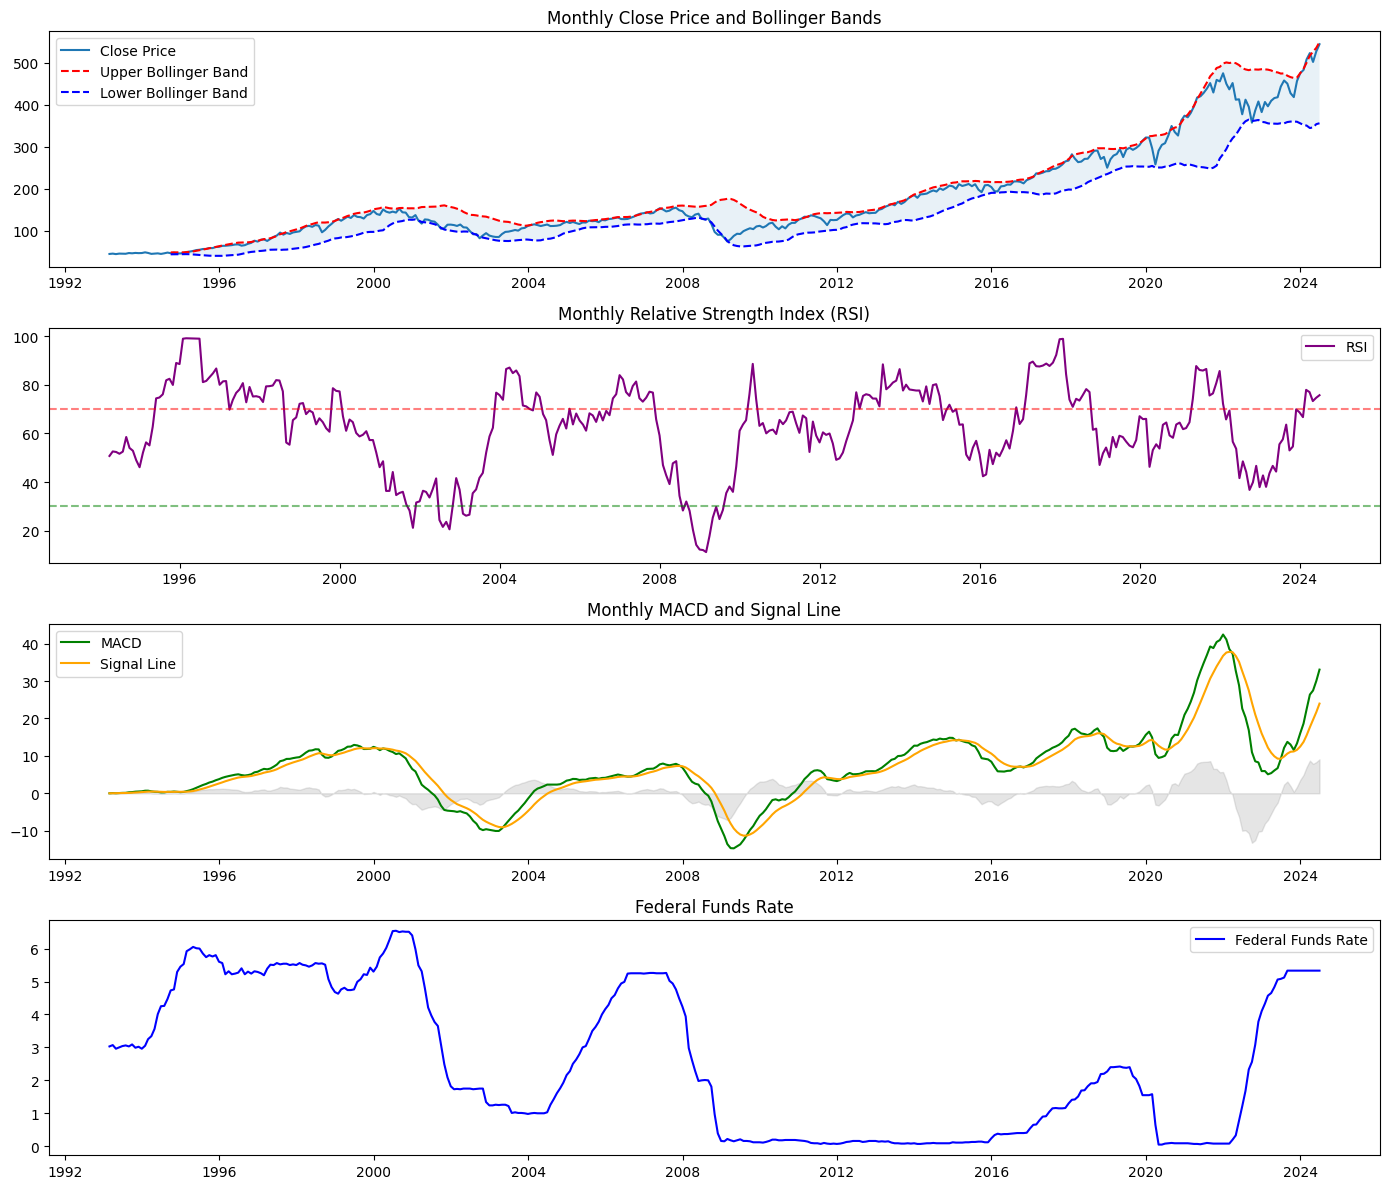

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

def load_data(ticker='SPY', start='1993-02-01', end=None):
    """
    Load historical data for a given ticker using yfinance.
    """
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df

def resample_monthly(df):
    """
    Resample the dataframe to monthly frequency.
    """
    df_monthly = df.resample('M').ffill()
    print("Resampled Data:\n", df_monthly.head())
    return df_monthly

def calculate_technical_indicators(df):
    """
    Calculate RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

    # Calculate MACD
    df['12 EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 EMA'] - df['26 EMA']
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    print("Technical Indicators:\n", df[['RSI', 'Upper Band', 'Lower Band', 'MACD', 'Signal Line']].head())
    return df

def plot_monthly_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Monthly Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(4, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Monthly Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(4, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('Monthly MACD and Signal Line')
    plt.legend()

    plt.tight_layout()
    plt.show()

def fetch_fed_data(series, start_date='2008-01-01'):
    """
    Fetch macroeconomic data from FRED.
    """
    return pdr.get_data_fred(series, start=start_date)

def merge_macro_data(financial_df, macro_df):
    """
    Merge financial data with macroeconomic data.
    """
    macro_df = macro_df.resample('M').ffill()  # Ensure macro data is also monthly
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    print("Merged Data:\n", merged_df.head())
    return merged_df

def plot_with_macro_data(merged_df):
    """
    Plot financial indicators with macroeconomic data.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12))

    # Plot Close Price and Bollinger Bands
    axs[0].plot(merged_df['Close'], label='Close Price')
    axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
    axs[0].set_title('Monthly Close Price and Bollinger Bands')
    axs[0].legend()

    # Plot RSI
    axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
    axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
    axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
    axs[1].set_title('Monthly Relative Strength Index (RSI)')
    axs[1].legend()

    # Plot MACD
    axs[2].plot(merged_df['MACD'], label='MACD', color='g')
    axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
    axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
    axs[2].set_title('Monthly MACD and Signal Line')
    axs[2].legend()

    # Plot Fed Funds Rate
    axs[3].plot(merged_df['FEDFUNDS'], label='Federal Funds Rate', color='blue')
    axs[3].set_title('Federal Funds Rate')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load SPY data
    ticker = 'SPY'
    start_date = '1993-02-01'
    df = load_data(ticker, start=start_date)
    
    # Resample to monthly frequency
    df_monthly = resample_monthly(df)
    
    # Calculate technical indicators
    df_monthly = calculate_technical_indicators(df_monthly)
    
    # Fetch Fed data
    fed_funds = fetch_fed_data('FEDFUNDS', start_date=start_date)
    
    # Merge financial data with macroeconomic data
    merged_df = merge_macro_data(df_monthly, fed_funds)
    
    # Plot the combined data
    plot_with_macro_data(merged_df)

if __name__ == "__main__":
    main()
